In [1]:
import warnings
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
import pandas as pd
from gensim.sklearn_api.w2vmodel import W2VTransformer
from gensim.sklearn_api.d2vmodel import D2VTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
from nltk.stem.snowball import SnowballStemmer
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn import datasets
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
from ast import literal_eval

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
tokenizer = RegexpTokenizer(r'\w+')
sbs = SnowballStemmer("dutch")

In [3]:
scores = pd.read_csv('Scores.csv', index_col=0).head(1)
scores = scores.dropna(axis=1).reset_index(drop=True)
scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])

In [4]:
df = pd.read_excel('Models.xlsx', index_col=0)
models = {}
for x,y in zip(df.Classifier,df.PIPELINE):
    exec(compile("a="+y,'','exec'))
    models[x] = Pipeline(a)
pipe = models[scores.estimator[0]]
pipe.set_params(**scores.drop([col for col in scores.columns if "__" not in col], axis=1).to_dict(orient='records')[0])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99999999, max_features=None, min_df=0.001,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=...cnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

In [5]:
#source: https://stackoverflow.com/questions/17260109/sample-two-pandas-dataframes-the-same-way/17260475
df = pd.read_csv("Handelingen.csv", index_col=0)
df = df.loc[df['speech category'] == 'Main Speech']
df = df.reset_index(drop=True)
df.tekst = df.text.apply(lambda x: ' '.join([sbs.stem(t) for t in tokenizer.tokenize(x)]))
rows = np.random.randint(5, size=len(df)).astype('bool')
dftrain = df[rows]
dftest = df[~rows]
pipe.fit(list(dftrain.text), list(dftrain.party))
predicted = pipe.predict(dftest.text)

In [6]:
print(classification_report(dftest.party, predicted))

              precision    recall  f1-score   support

      50PLUS       0.96      0.83      0.89        87
         CDA       0.75      0.72      0.74       460
ChristenUnie       0.83      0.73      0.78       249
         D66       0.69      0.77      0.73       445
  GroenLinks       0.83      0.67      0.74       236
         PVV       0.79      0.80      0.80       389
        PvdA       0.65      0.69      0.67       461
        PvdD       0.85      0.83      0.84        83
         SGP       0.83      0.81      0.82       149
          SP       0.72      0.81      0.77       510
         VVD       0.73      0.67      0.70       429

 avg / total       0.75      0.75      0.75      3498



In [7]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

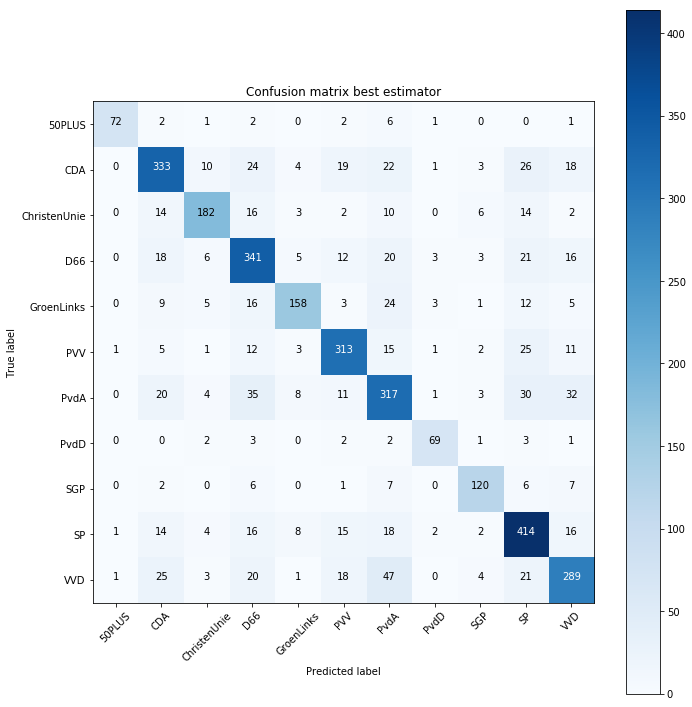

In [8]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(dftest.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.show()

In [9]:
cnf_matrix

array([[ 72,   2,   1,   2,   0,   2,   6,   1,   0,   0,   1],
       [  0, 333,  10,  24,   4,  19,  22,   1,   3,  26,  18],
       [  0,  14, 182,  16,   3,   2,  10,   0,   6,  14,   2],
       [  0,  18,   6, 341,   5,  12,  20,   3,   3,  21,  16],
       [  0,   9,   5,  16, 158,   3,  24,   3,   1,  12,   5],
       [  1,   5,   1,  12,   3, 313,  15,   1,   2,  25,  11],
       [  0,  20,   4,  35,   8,  11, 317,   1,   3,  30,  32],
       [  0,   0,   2,   3,   0,   2,   2,  69,   1,   3,   1],
       [  0,   2,   0,   6,   0,   1,   7,   0, 120,   6,   7],
       [  1,  14,   4,  16,   8,  15,  18,   2,   2, 414,  16],
       [  1,  25,   3,  20,   1,  18,  47,   0,   4,  21, 289]],
      dtype=int64)